# Capstone - Malarial Cell Classifier

## Imports of import

In [1]:
# Imports of import.
import matplotlib.pyplot as plt
import numpy as np
import os

# Keras imports.
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Creating the data generator that feeds the neural network

In [2]:
# Constants that filter throughout thta I might want to change with one edit.
# Batch size may or may not make a difference, but I wanted to be able to edit it:
batch_size = 20

# If the calculation is taking too long, I want to be able to change the number of calculation steps easily
steps_per_epoch = 2500/batch_size

# I also want to be able to change the training steps easily
validation_steps = 1000/batch_size

# I wanted to be able to change the number of epochs of training involved.
epochs = 100

# The image_size constant allows me to change the resultant size of the images in case a given image size is
# to large for the computer's memory to handle - turns out 150x150 IS too large...
image_size = 75

# Image generator: This portion of the code takes the dataset and each pass through the entire dataset, it
# generates a slightly different image based on the parameters given, so that my 27K dataset becomes more like
# 270K in size when the individual images are compared.
datagen = ImageDataGenerator(rescale          = 1.0/255.0, # The data need to be rescaled to a range of [0,1]
                             shear_range      = 0.20,      # Making a parallelogram out of a square 
                             zoom_range       = 0.20,      # Zooming in or out by 20%
                             horizontal_flip  = True,      # Flipping the image horizontally
                             vertical_flip    = True,      # Flipping the image vertically
                             validation_split = 0.25)      # How much of the data is reserved as the test data

# This generetor uses the image generator to create a train/test/split from the images' location on disk and then
# feeds it to the neural network for me without any headaches.
train_generator = datagen.flow_from_directory('./cell_images',
                                              target_size = (image_size, image_size),
                                              batch_size  = batch_size,
                                              class_mode  = 'binary',
                                              subset      = 'training')

validation_generator = datagen.flow_from_directory('./cell_images',
                                                   target_size = (image_size, image_size),
                                                   batch_size  = batch_size,
                                                   class_mode  = 'binary',
                                                   subset      = 'validation')

Found 20660 images belonging to 2 classes.
Found 6886 images belonging to 2 classes.


# Creating the neural network

In [3]:
# The base model is Sequential, so this is an instantiation of that.
model = Sequential()

# Adding the first convolutional layer to the network requires setting up the input_shape.
# All of the additional layers do not require that.
model.add(Conv2D(image_size,                                # One node per pixel in the first layer
                 kernel_size = (3, 3),                      # The kernel is the edge detector for the network              
                 input_shape = (image_size, image_size, 3), # Required first layer input
                 activation  = 'relu'))                     # Activation is 'relu' for general neural networks

# MaxPooling reduces the size of the input in two dimensions, so (2,2) cuts the input to the next layer in half.
model.add(MaxPooling2D(pool_size = (2, 2)))

# The next convolutional layer will be twice the size of the previous layer, everything else being the same.
model.add(Conv2D(image_size*2,                              
                 kernel_size = (3, 3),
                 activation  = 'relu'))

# Cutting the next layer's input by half again.
model.add(MaxPooling2D(pool_size = (2, 2)))

# Same as the previous convolutional layer.
model.add(Conv2D(image_size*2,
                 kernel_size = (3, 3),
                 activation  = 'relu'))

# Another pooling layer to cut the output in half yet again
model.add(MaxPooling2D(pool_size = (2, 2)))

# Last convolutional layer is back the original layer in size, all else being equal.
model.add(Conv2D(image_size,
                 kernel_size = (3, 3),
                 activation  = 'relu'))

# Now the convolutional neural network's information is being passed to a regular Dense neural network.  This
# change requires the Flatten() layer so that the data is now a 1-D array when the Dense layers see it.
model.add(Flatten())

# I decided to start relatively big with 200 nodes in the network:
model.add(Dense(300,
                activation  = 'relu'))

# ...and then half it again:
model.add(Dense(150,
                activation  = 'relu'))

# And now it's time to get the output.  A binary classification problem requires a 1-node output with a sigmoid
# activation.
model.add(Dense(1,
                activation  = 'sigmoid'))

# A nice picture of the layers of the neural network and the sizes of the inputs/outputs between the layers.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 75)        2100      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 75)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 150)       101400    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 150)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 150)       202650    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 150)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 75)          101325    
__________

## Compiling the neural network

In [4]:
# The required compilation step to finish creating the neural network.
# binary_crossentropy is the loss function used for binary classification.
model.compile(loss      = 'binary_crossentropy',
              optimizer = 'adam',                # I use the adam optimizer because we were taught that.
              metrics   = ['accuracy'])          # I'll be measuring the performance through accuracy.

## Fitting the neural network

In [5]:
# I want my model to stop if it isn't getting any better after 20 consecutive epochs.
early_stopping = EarlyStopping(monitor  = 'val_loss',
                               patience = 20,
                               verbose  = 1)

# I also want to attempt to reduce the learning rate 20% of the way into my EarlyStopping patience.
reduce_learning_rate = ReduceLROnPlateau(monitor  = 'val_loss',
                                         patience = 4,
                                         factor   = 0.15,
                                         min_lr   = 0.0005)

# Now it's time to fit and test the model:
cnn = model.fit_generator(train_generator,
                          steps_per_epoch  = steps_per_epoch,
                          epochs           = epochs,
                          callbacks        = [early_stopping, reduce_learning_rate],
                          validation_data  = validation_generator,
                          validation_steps = validation_steps)

Epoch 1/100
125/125 [==============================] - 150s 1s/step - loss: 0.6942 - acc: 0.5272 - val_loss: 0.6924 - val_acc: 0.4900
Epoch 2/100
125/125 [==============================] - 154s 1s/step - loss: 0.6725 - acc: 0.5680 - val_loss: 1.1770 - val_acc: 0.5560
Epoch 3/100
125/125 [==============================] - 176s 1s/step - loss: 0.4835 - acc: 0.7956 - val_loss: 0.4648 - val_acc: 0.7600
Epoch 4/100
125/125 [==============================] - 146s 1s/step - loss: 0.3008 - acc: 0.9080 - val_loss: 0.2847 - val_acc: 0.8960
Epoch 5/100
125/125 [==============================] - 154s 1s/step - loss: 0.2555 - acc: 0.9300 - val_loss: 0.1414 - val_acc: 0.9580
Epoch 6/100
125/125 [==============================] - 147s 1s/step - loss: 0.1956 - acc: 0.9404 - val_loss: 0.1678 - val_acc: 0.9430
Epoch 7/100
125/125 [==============================] - 147s 1s/step - loss: 0.1930 - acc: 0.9416 - val_loss: 0.1853 - val_acc: 0.9523
Epoch 8/100
125/125 [==============================] - 149s 1s

In [6]:
# Saving the model in case I want to run multiple learning trials
# Also, each tweak of the neural network is going to be saved separately, so I don't want to do any more work
# editing this line everytime I do a tweak and I don't want it to save if the accuracy was not at least 90%.
file_names = os.listdir('./working_model_saves/')
model.save(f'./working_model_saves/cnn_malarial_cell_identifier_mk{len(file_names)+1}.h5')
del file_names

## Plotting the accuracy changes over the training period

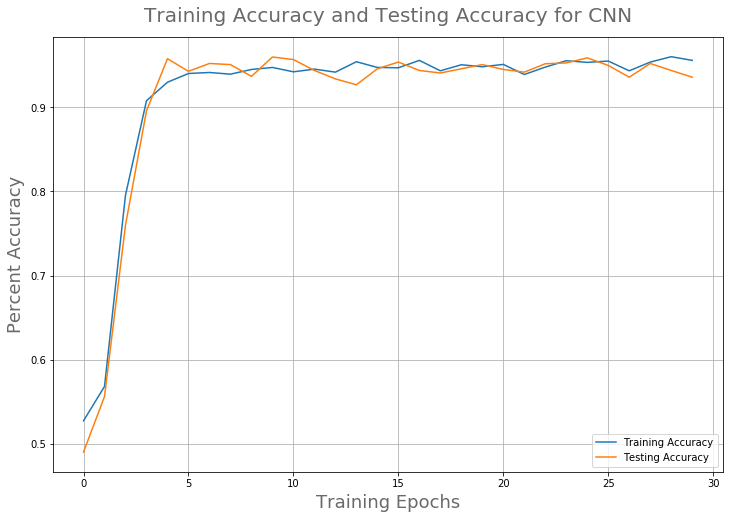

In [9]:
# Now that the model is fit and tested, let's see how the training went:
plt.figure(figsize  = (12,8))
plt.plot(np.arange(len(cnn.history['acc'])),
         cnn.history['acc'],
         label      = 'Training Accuracy');
plt.plot(np.arange(len(cnn.history['val_acc'])),
         cnn.history['val_acc'],
         label      = 'Testing Accuracy');
plt.title('Training Accuracy and Testing Accuracy for CNN',
           color    = 'dimgrey',
           fontsize = 20,
           pad      = 15);
plt.xlabel('Training Epochs',
           color    = 'dimgrey',
           fontsize = 18,
           labelpad = 5);
plt.ylabel('Percent Accuracy',
           color    = 'dimgrey',
           fontsize = 18,
           labelpad = 5);
plt.grid(True);
plt.legend();